# Estimating Palantir and DPT pseudotime for ATO DN onwards

In [ ]:
import palantir

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scanpy as sc
import numpy as np
import warnings
import anndata
import pandas as pd
import numpy as np
# Inline plotting
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

In [2]:
palantir.__version__

'1.3.1'

In [3]:
input_dir ='../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/'
adata_ref = anndata.read_h5ad(input_dir +'PanfetalATO_SPT_DNonwards_gplvm_ATO_24012023.h5ad_monocle_slingshot.h5ad') 

In [99]:
adata = adata_ref.copy() 

/opt/conda/envs/palantir_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


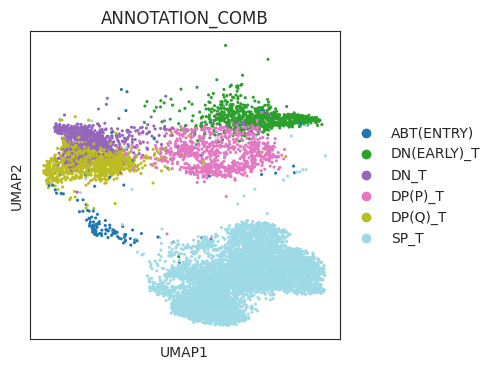

In [100]:
sc.pl.embedding(adata , basis='umap', color='ANNOTATION_COMB', s=20 )

adata.obs['clusters'] = adata.obs.ANNOTATION_COMB

In [101]:
adata.X = adata.layers['counts']

In [102]:
adata.X.data

array([2., 1., 2., ..., 2., 1., 6.], dtype=float32)

In [103]:
adata_original = adata.copy()

In [104]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_per_cell(adata, 10000) 
sc.pp.log1p(adata)
sc.pp.pca(adata)

In [105]:
adata.X.data

array([0.5900713 , 0.33794153, 0.5900713 , ..., 0.4529326 , 0.25189355,
       1.0001738 ], dtype=float32)

In [106]:
adata_original.X.data

array([2., 1., 2., ..., 2., 1., 6.], dtype=float32)

In [107]:
#sc.tl.score_genes(adata, gene_list=['LGR5', 'ASCL2', 'RGMB', 'OLFM4'] , score_name='start_score')
#sc.pl.embedding(adata , basis='umap_scvi', color=['level_3_annot','start_score'], s=20 )

In [108]:
# same as used for monocle and slingshot
start_cell_id = 730 # np.argmax(adata.obs.start_score)
start_cell =  adata.obs_names[start_cell_id] 
start_cell_id 

730

In [109]:
start_cell

'TTGAACGAGAAACCTA-1-2'

In [110]:
adata[adata.obs_names == start_cell].obs.ANNOTATION_COMB

TTGAACGAGAAACCTA-1-2    DN(EARLY)_T
Name: ANNOTATION_COMB, dtype: category
Categories (1, object): ['DN(EARLY)_T']

In [111]:
adata

AnnData object with n_obs × n_vars = 10089 × 17718
    obs: 'ANNOTATION_COMB', 'time', 'n_counts', 'refined_time', 'bin_ids', 'monocle_pseudotime', 'slingshot_pseudotime', 'palantir_pseudotime', 'clusters'
    var: 'n_cells'
    uns: 'ANNOTATION_COMB_colors', 'log1p', 'pca'
    obsm: 'X_gplvm', 'X_scVI', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [112]:
np.random.seed(5)
# Run diffusion maps
palantir.utils.run_diffusion_maps(adata, pca_key = 'X_scVI')
ms_data = palantir.utils.determine_multiscale_space(adata)
ms_data
#ms_data.index = adata.obs_names

,0,1
AAACCTGCAACTGGCC-1-2,3.060427,1.964334
AAACGGGTCCCTCAGT-1-2,3.304730,1.901821
AAACGGGTCTTGACGA-1-2,3.176849,1.883163
AAAGATGGTTCCGGCA-1-2,3.642053,1.771197
AAAGTAGTCAAACCAC-1-2,3.531222,1.950733
...,...,...
TTTGTCACAGGGTACA-1-5,-2.497264,-0.106372
TTTGTCAGTAGCACGA-1-5,-2.554623,-0.094558
TTTGTCAGTAGTGAAT-1-5,4.932781,0.237840
TTTGTCATCGGATGTT-1-5,5.077020,0.064166


In [113]:
start_cell_id

730

In [114]:
start_cell

'TTGAACGAGAAACCTA-1-2'

In [115]:
np.random.seed(1234)
np.random.choice(np.where(adata.obs.ANNOTATION_COMB == 'SP_T')[0]) 

5879

In [116]:
# same as used for monocle and slingshot
end_cell_id = 5879 # np.argmax(adata.obs.start_score)
end_cell =  adata.obs_names[end_cell_id] 
end_cell_id 

5879

In [117]:
end_cell

'CCGGTAGGTCATCGGC-1-5'

In [118]:
adata

AnnData object with n_obs × n_vars = 10089 × 17718
    obs: 'ANNOTATION_COMB', 'time', 'n_counts', 'refined_time', 'bin_ids', 'monocle_pseudotime', 'slingshot_pseudotime', 'palantir_pseudotime', 'clusters'
    var: 'n_cells'
    uns: 'ANNOTATION_COMB_colors', 'log1p', 'pca', 'DM_EigenValues'
    obsm: 'X_gplvm', 'X_scVI', 'X_umap', 'X_pca', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'DM_Kernel', 'DM_Similarity'

In [119]:
np.random.seed(5)



terminal_states = pd.Series(
    ["SP_T"],
    index=[end_cell],
)


pr_res = palantir.core.run_palantir(ms_data, early_cell=start_cell , use_early_cell_as_start=True, num_waypoints=500, 
                                   terminal_states = terminal_states)

Sampling and flocking waypoints...
Time for determining waypoints: 0.015012804667154949 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.21056156158447265 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


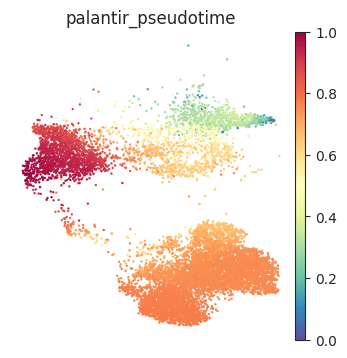

In [120]:
#pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]
palantir_pseudotime = []
for c in adata.obs_names:
    palantir_pseudotime.append(pr_res.pseudotime[c])
adata.obs['palantir_pseudotime'] = palantir_pseudotime
#sc.pl.embedding(adata, basis='umap_scvi', color='palantir_pseudotime', save='Palantir_pseudotime_umap_scvi.pdf', frameon=False)
sc.pl.embedding(adata, basis='umap', color='palantir_pseudotime', frameon=False)

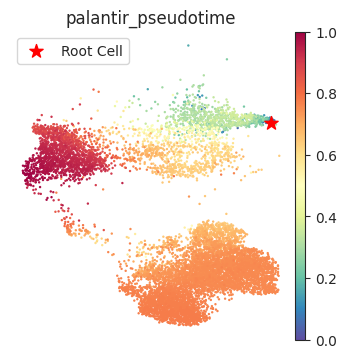

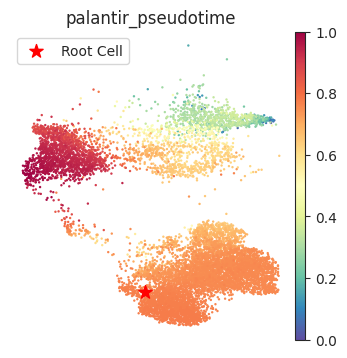

In [121]:
sc.pl.embedding(adata, basis='umap', color=['palantir_pseudotime'], show=False, frameon=False)
single_cell_umap_coords = list(adata.obsm['X_umap'][start_cell_id])  # Replace x and y with actual UMAP coordinates
plt.scatter(single_cell_umap_coords[0], single_cell_umap_coords[1], color='red', marker='*', s=100, label='Root Cell')
plt.legend()
#plt.savefig('ztest.pdf')

sc.pl.embedding(adata, basis='umap', color=['palantir_pseudotime'], show=False, frameon=False)
single_cell_umap_coords = list(adata.obsm['X_umap'][end_cell_id])  # Replace x and y with actual UMAP coordinates
plt.scatter(single_cell_umap_coords[0], single_cell_umap_coords[1], color='red', marker='*', s=100, label='Root Cell')
plt.legend()


In [122]:
adata[np.where(adata.obs.palantir_pseudotime ==  np.max(adata.obs.palantir_pseudotime)) [0][0],: ].obs.ANNOTATION_COMB


AAGCCGCTCTGTACGA-1-3    DP(Q)_T
Name: ANNOTATION_COMB, dtype: category
Categories (1, object): ['DP(Q)_T']

In [123]:
end_cell
start_cell

'TTGAACGAGAAACCTA-1-2'

In [124]:
adata[ start_cell] .obs.ANNOTATION_COMB

TTGAACGAGAAACCTA-1-2    DN(EARLY)_T
Name: ANNOTATION_COMB, dtype: category
Categories (1, object): ['DN(EARLY)_T']

In [125]:
adata[ end_cell] .obs.ANNOTATION_COMB

CCGGTAGGTCATCGGC-1-5    SP_T
Name: ANNOTATION_COMB, dtype: category
Categories (1, object): ['SP_T']

/opt/conda/envs/palantir_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


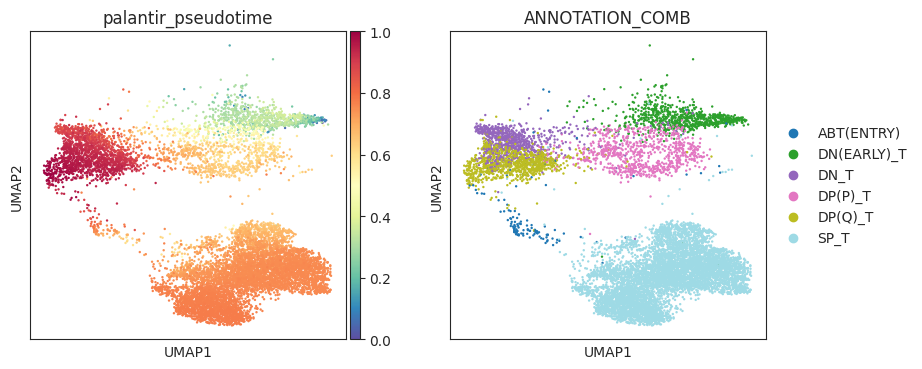

In [126]:
sc.pl.embedding(adata, basis='umap', color=['palantir_pseudotime','ANNOTATION_COMB'])

/opt/conda/envs/palantir_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


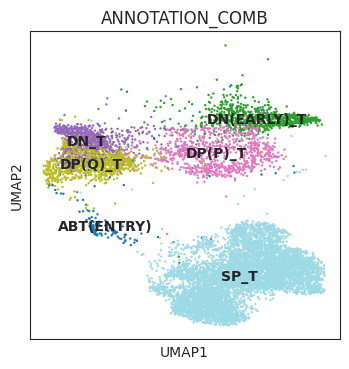

In [127]:
sc.pl.embedding(adata, basis='umap', color=['ANNOTATION_COMB'], legend_loc='on data')

In [128]:
adata_temp = adata.copy()
adata_temp.obsm['X_umap'] = adata_temp.obsm['X_umap']

In [129]:
adata_ref.obs['palantir_pseudotime'] = adata.obs['palantir_pseudotime']

In [130]:
adata_ref

AnnData object with n_obs × n_vars = 10089 × 17718
    obs: 'ANNOTATION_COMB', 'time', 'n_counts', 'refined_time', 'bin_ids', 'monocle_pseudotime', 'slingshot_pseudotime', 'palantir_pseudotime'
    var: 'n_cells'
    uns: 'ANNOTATION_COMB_colors', 'log1p'
    obsm: 'X_gplvm', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/opt/conda/envs/palantir_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


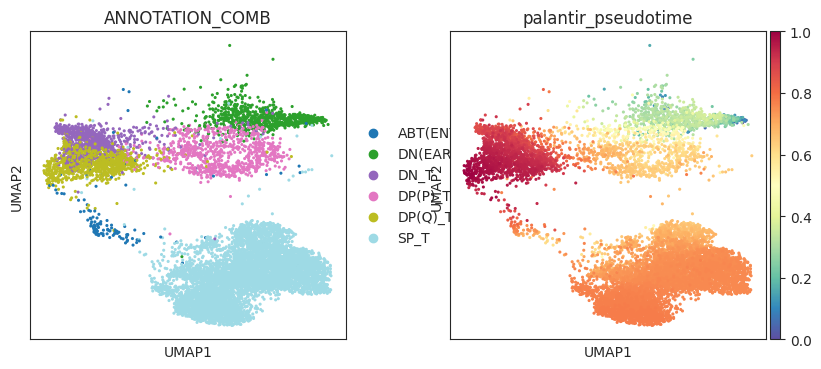

In [131]:
sc.pl.embedding(adata_ref , basis='umap', color= ['ANNOTATION_COMB', 'palantir_pseudotime'], s=20 )

In [134]:
input_dir

'../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/'

In [133]:
adata_ref.write_h5ad('revision_data/PanfetalATO_SPT_DNonwards_gplvm_ATO_24012023.h5ad_monocle_slingshot_palantir.h5ad')

# DPT

In [2]:
import palantir

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scanpy as sc
import numpy as np
import warnings
import anndata
import pandas as pd
import numpy as np
# Inline plotting
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

palantir.__version__


'1.3.1'

In [3]:
input_dir ='../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/Revision/'
adata_ref = anndata.read_h5ad('revision_data/PanfetalATO_SPT_DNonwards_gplvm_ATO_24012023.h5ad_monocle_slingshot_palantir.h5ad')
adata = adata_ref.copy() 

In [7]:
adata = adata_ref.copy() 

====== DPT RUN ====== 
         Falling back to preprocessing with `sc.pp.pca` and default params.


/opt/conda/envs/palantir_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


730


/tmp/ipykernel_20613/2825574311.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_sub.obs['rootcell'][rootcell] = 1


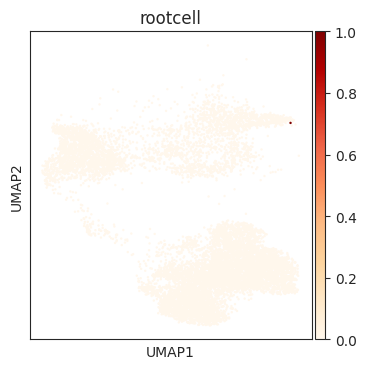

In [8]:
def estimate_dpt_pseudotime(adata_WT,ANNO_COLNAME):
    print('====== DPT RUN ====== ')
    #sc.pp.normalize_per_cell(adata_WT, 10000) 
    #sc.pp.log1p(adata_WT)
    sc.pp.highly_variable_genes(adata_WT, n_top_genes=4000)
    adata_WT.raw = adata_WT.copy()
    adata_WT = adata_WT[:, adata_WT.var.highly_variable]
    sc.pp.neighbors(adata_WT)
    #sc.tl.umap(adata_WT)
    #sc.tl.leiden(adata_WT, key_added='leiden_normal', resolution=0.1)
    ref_sub = adata_WT.copy()
    sc.pp.neighbors(ref_sub,use_rep='X_scVI')
    sc.tl.diffmap(ref_sub)
    sc.pp.neighbors(ref_sub,use_rep='X_diffmap')
    sc.tl.leiden(ref_sub, key_added='leiden_diffmap', resolution=0.1)
    
    rootcell = 730# np.argmax(ref_sub.obs.dpt_start_score)
    
    print(rootcell)
    ref_sub.uns['iroot'] = rootcell
    ref_sub.obs['rootcell'] = 0
    ref_sub.obs['rootcell'][rootcell] = 1
    sc.pl.umap(ref_sub,color='rootcell',color_map='OrRd')
    sc.tl.dpt(ref_sub)
    return ref_sub



temp = estimate_dpt_pseudotime(adata.copy(), 'ANNOTATION_COMB')

/opt/conda/envs/palantir_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


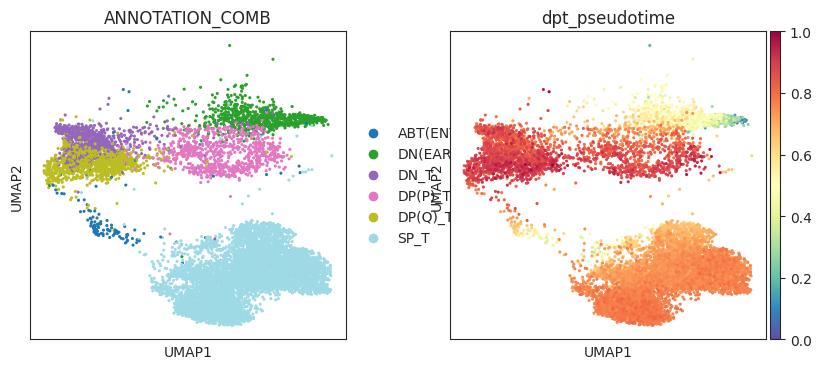

In [9]:
sc.pl.embedding(temp , basis='umap', color= ['ANNOTATION_COMB', 'dpt_pseudotime'], s=20 )

In [10]:
adata_ref.obs['dpt_pseudotime'] = temp.obs['dpt_pseudotime'] 

In [15]:
adata_ref

AnnData object with n_obs × n_vars = 10089 × 17718
    obs: 'ANNOTATION_COMB', 'time', 'n_counts', 'refined_time', 'bin_ids', 'monocle_pseudotime', 'slingshot_pseudotime', 'palantir_pseudotime', 'dpt_pseudotime'
    var: 'n_cells'
    uns: 'ANNOTATION_COMB_colors', 'log1p'
    obsm: 'X_gplvm', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [14]:
adata_ref.write_h5ad('revision_data/PanfetalATO_SPT_DNonwards_gplvm_ATO_24012023.h5ad_monocle_slingshot_palantir.h5ad')